## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SIMClassifier

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

```python
from pysim import SIMClassifier
clf = SIMClassifier(method="first_order", spline="a_spline", reg_lambda=0.1, reg_gamma=0.1, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Usage**

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- spline: The type of spline method. default="a_spline"

        "p_spline": p-spline (from pygam package)
    
        "p_spline_mono": p-spline with monotonic constraint (from pygam package)
    
        "a_spline": adaptive spline where knots are automatically selected (see Goepp, V., Bouaziz, O. and Nuel, G., 2018. Spline regression with automatic knot selection. arXiv preprint arXiv:1808.01770.)

- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=0.1, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

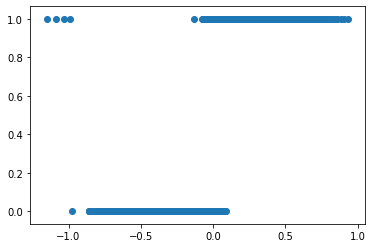

In [3]:
plt.scatter(np.dot(x, beta), y)

The best hyperparameter combination can be selected via cross-validation

In [4]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIMClassifier(degree=2, knot_num=20, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:   47.4s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   57.4s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   57.6s finished


CPU times: user 6.13 s, sys: 14.3 s, total: 20.4 s
Wall time: 58 s


/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/aspline.py:172: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(omega) >= self.EPS) * np.isfinite(omega)


In [5]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 0.01, 'reg_lambda': 0.05}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [6]:
clf = grid.best_estimator_
clf

SIMClassifier(degree=2, knot_num=20, method='first_order', random_state=0,
              reg_gamma=0.01, reg_lambda=0.05, spline='a_spline')

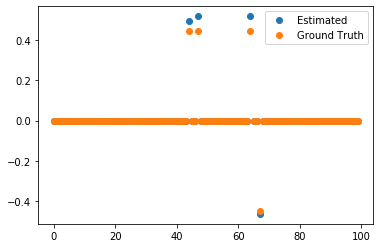

In [7]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

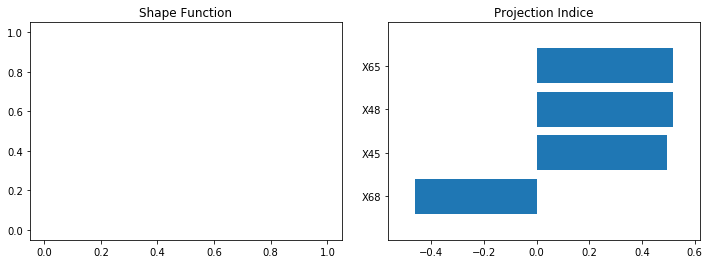

In [8]:
grid.best_estimator_.visualize()

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [9]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

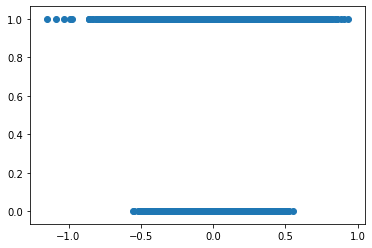

In [10]:
plt.scatter(np.dot(x, beta), y)

In [11]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIMClassifier(degree=2, knot_num=20, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:   46.1s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   52.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   56.3s finished


CPU times: user 11.7 s, sys: 27.3 s, total: 39 s
Wall time: 57 s


/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/aspline.py:172: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(omega) >= self.EPS) * np.isfinite(omega)


In [12]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 0.01, 'reg_lambda': 0.05}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [13]:
clf = grid.best_estimator_
clf

SIMClassifier(degree=2, knot_num=20, method='first_order', random_state=0,
              reg_gamma=0.01, reg_lambda=0.05, spline='a_spline')

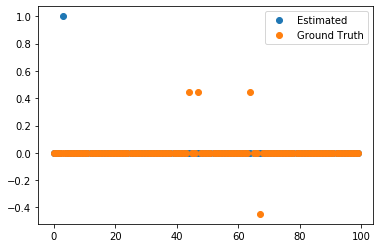

In [14]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

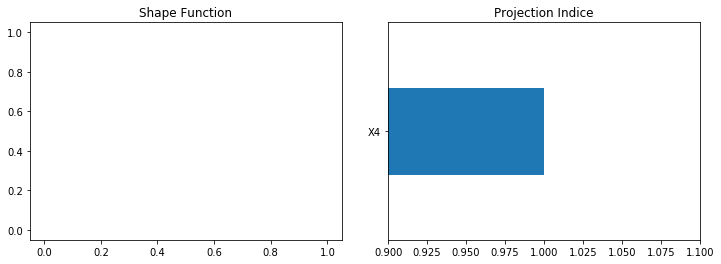

In [15]:
grid.best_estimator_.visualize()

In [36]:
from patsy import dmatrix, build_design_matrices

def diff_matrix(order, knot_num):
    results = [] # a container to collect the rows
    n_rows = order + 2
    for _ in range(n_rows): 
        row = [1] # a starter 1 in the row
        if results: # then we're in the second row or beyond
            last_row = results[-1] # reference the previous row
            row.extend([sum(pair) for pair in zip(last_row, last_row[1:])])
            row.append(1)
        results.append(row) # add the row to the results.

    diss_operator = [] # a container to collect the rows
    for i, item in enumerate(np.array(row)):
        diss_operator.append(item * (-1) ** i)
    diss_operator.reverse()
    D = np.zeros((knot_num, knot_num + order + 1), dtype=np.float32)
    for i in range(knot_num):
        D[i,i:(i+order+2)] = diss_operator
    return D


# x = np.dot(x, grid.best_estimator_.beta_)
# y = y
clf = grid.best_estimator_.shape_fit_
n_samples = x.shape[0]
sample_weight = np.ones(n_samples)

knots = list(np.linspace(clf.xmin, clf.xmax, clf.knot_num + 2, dtype=np.float32)[1:-1])
xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1",
               {"x": [clf.xmin, clf.xmax], "knots": knots, "degree": clf.degree})
init_basis = np.asarray(build_design_matrices([xphi.design_info],
                  {"x": x, "knots": knots, "degree": clf.degree})[0])
D = diff_matrix(clf.degree, clf.knot_num)
w = np.ones([clf.knot_num], dtype=np.float32) 
W = np.diag(w)

tempy = y.copy()
tempy[tempy==0] = 0.01
tempy[tempy==1] = 0.99
BWB = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), init_basis, axes=([0], [0]))
BWY = np.tensordot(init_basis * sample_weight.reshape([-1, 1]), clf.inv_link(tempy), axes=([0], [0]))
update_a = np.dot(np.linalg.pinv(BWB + clf.reg_gamma * D.T.dot(W).dot(D)), BWY)
for i in range(clf.maxiter):
    for j in range(clf.maxiter_irls):
        lp = np.dot(basis, update_a)
        mu = clf.link(lp)
        omega = mu * (1 - mu)
        mask = (np.abs(omega) >= clf.EPS) * np.isfinite(omega)
        mask = mask.ravel()
        if np.sum(mask) == 0:
            break

        BW = basis[mask, :] * sample_weight[mask].reshape([-1, 1])
        BWOB = np.tensordot(BW * omega[mask].reshape([-1, 1]), basis[mask, :], axes=([0], [0]))
        update_a = np.dot(np.linalg.pinv(BWOB + clf.reg_gamma * D.T.dot(W).dot(D)),
                    BWOB.dot(update_a) + np.tensordot(BW, tempy[mask] - mu[mask], axes=([0], [0])))
    update_w = 1 / (np.dot(D, update_a) ** 2 + clf.epsilon ** 2)
    W = np.diag(update_w.reshape([-1]))

clf.selected_knots_ = list(np.array(knots)[np.reshape(update_w * np.dot(D, update_a) ** 2 > clf.threshold, [-1])])
clf.selected_xphi_ = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1", 
       {"x": [clf.xmin, clf.xmax], "knots": clf.selected_knots_, "degree": clf.degree})
selected_basis = np.asarray(build_design_matrices([clf.selected_xphi_.design_info],
                  {"x": x, "knots": clf.selected_knots_, "degree": clf.degree})[0])

seBWB = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), selected_basis, axes=([0], [0]))
seBWY = np.tensordot(selected_basis * sample_weight.reshape([-1, 1]), clf.inv_link(tempy), axes=([0], [0]))
clf.coef_ = np.dot(np.linalg.pinv(seBWB), seBWY)
clf.coef_

array([-4.82361057,  2.75930776, -0.82800657, -0.47753805,  1.02776569,
       -1.23536788, -0.12714771, -0.57135422, -0.84358064, -0.3604439 ,
       -0.37396999, -0.67357024,  0.25008187, -0.18284148, -0.30287089,
       -1.04697508,  3.48829281, -3.86956844, -1.15795929, -3.94384147])

In [34]:
tempy

array([1., 1., 0., ..., 0., 1., 0.])